In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 206 (delta 97), reused 189 (delta 87), pack-reused 0
Receiving objects: 100% (206/206), 64.85 MiB | 31.25 MiB/s, done.
Resolving deltas: 100% (97/97), done.


---
Load Libraries

In [2]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

C:\Users\deela\AppData\Local\Temp\ipykernel_9644\1470553114.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

---
Set Global Variables

In [4]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [23]:
# setup model configurations
config = {
    # general information
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    "sem-space": 'attr',
    # model training configs
    "lr": 0.001,
    "imu_alpha": 0.0001,
    "n_epochs": 5,
    "optimizer": "adam",
    "batch_size": 32,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 42, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 64,
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "freq": 50,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,
}

In [6]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

---
Load Data

In [8]:
IMU_data_path = './data/PAMAP2_Dataset/Protocol/'
dataReader = PAMAP2Reader(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:64: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [9]:
def load_attribute(fpath):
    with open(fpath, "r") as pf:
        json_data = json.load(pf)

    activity_dict = json_data["Activity"]
    attribute_dict = json_data["Attribute"]
    attr_met = np.array(list(json_data["Mark"].values()))
    return activity_dict, attribute_dict, attr_met

In [10]:
# load video dataset
Attr_data_path  = './data/PAMAP2_Dataset/PAMAP2_attributes.json'
activity_dict, attribute_dict, attr_mat = load_attribute(Attr_data_path)
_, attr_size = attr_mat.shape

---
Utils

In [11]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [12]:
## IMU Dataset

class IMUDataset(Dataset):
    def __init__(self, data, actions, attributes, action_classes):
        super(IMUDataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        y_feat = self.attributes[target, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]
    
    def getClassFeatures(self):
        cls_feat = self.attributes[self.action_classes, ...]
        return cls_feat

In [13]:
## IMU Encoder Model

class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=dropout)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

In [14]:
def loss_cross_entropy(y_pred, cls, selected_features, loss_fn=nn.CrossEntropyLoss(reduction="mean")):
    num_classes = selected_features.size()[0]
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb,cls)
    return loss

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    _, feature_size = y_pred.size()
    loss = loss_fn(y_pred, y_feat)*(1/feature_size)
    return loss

def predict_class(y_pred, selected_features):
    num_classes = selected_features.size()[0]
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [15]:
def train_step(model, dataloader, dataset, optimizer, loss_module, device, phase='train', loss_alpha=0.7):
    model = model.train()
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0, "accuracy": 0}
    semantic_space = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), semantic_space, loss_fn=loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])
                loss = feat_loss + loss_alpha*class_loss

            class_output = predict_class(feat_output, semantic_space)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                N = len(targets)
                metrics['loss'] = loss.item()/N # add total loss of batch
                metrics['feat. loss'] = feat_loss.item()/N
                metrics['classi. loss'] = class_loss.item()/N

            # convert feature vector into action class
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class, normalize=True)
            tepoch.set_postfix(metrics)   
    
    # metrics['accuracy'] = metrics['accuracy']/metrics['samples'] # average loss per sample for whole epoch
    # tepoch.set_postfix(metrics)  
    return metrics

In [16]:
def eval_step(model, dataloader, dataset, loss_module, device, class_names, phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.1):
    model = model.eval()
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}
    semantic_space = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), semantic_space, loss_fn=loss_module['class'])
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])
                loss = feat_loss + loss_alpha*class_loss
            
            class_output = predict_class(feat_output, semantic_space)

            with torch.no_grad():
                N = len(targets)
                metrics['loss'] += loss.item()/N  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()/N
                metrics['classi. loss'] += class_loss.item()/N

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(class_output.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [17]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

---

---
Temp

In [18]:
# test model 
sample_input = torch.randn((32, 120, 42))
model = IMUEncoder(in_ft=42, d_model=128, num_heads=2, ft_size=128, n_classes=2, max_len=120, dropout=0.1)
sample_output = model(sample_input)
sample_output.shape

torch.Size([32, 128])

In [19]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [20]:
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)

In [21]:
data_dict['train']['X'].shape,data_dict['eval-seen']['X'].shape,data_dict["test"]["X"].shape

((16752, 105, 27), (4189, 105, 27), (5608, 105, 27))

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

all preds >  [ 2  2  4 ...  4  2 10]  all targets >  [ 5  5  4 ...  4  8 11]
Overall accuracy: 0.677



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

all preds >  [ 2  6  8 ... 10  6  1]  all targets >  [ 2  6 13 ... 11  6  1]
Overall accuracy: 0.711



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

all preds >  [ 2  2  9 ... 10  8  9]  all targets >  [ 5  2  9 ... 10  8  9]
Overall accuracy: 0.862



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

all preds >  [ 5  0 10 ...  8  9  5]  all targets >  [ 5  0 10 ...  8  9  5]
Overall accuracy: 0.880



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

all preds >  [10  5 10 ...  3  6  2]  all targets >  [ 4  5 10 ...  3  6  2]
Overall accuracy: 0.826



unseen:   0%|          | 0/175 [00:00<?, ?batch/s]

all preds >  [1 3 1 ... 1 2 3]  all targets >  [2 3 3 ... 2 1 3]
Overall accuracy: 0.510

{'accuracy': 0.5101785714285715, 'precision': 0.5230347034049847, 'recall': 0.5597445611736727, 'f1': 0.5174032579653874, 'samples': 5600, 'loss': 43.57977968454361, 'feat. loss': 43.55574560165405, 'classi. loss': 240.34084820747375}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'descending stairs']
seen classes >  [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16]
unseen classes >  [3, 17, 1, 11]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

all preds >  [10  4  6 ...  1  0  6]  all targets >  [10 13  6 ...  1  0  6]
Overall accuracy: 0.632



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

all preds >  [ 1  0  9 ...  3  3 10]  all targets >  [1 0 9 ... 3 3 5]
Overall accuracy: 0.691



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

all preds >  [10  6  5 ...  6  4  8]  all targets >  [11  6  5 ...  6  4  8]
Overall accuracy: 0.733



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

all preds >  [10  4  1 ...  6  3  0]  all targets >  [11  2  1 ...  6  3  0]
Overall accuracy: 0.760



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

all preds >  [10  8  0 ...  9  9  1]  all targets >  [10  8  0 ...  9  9  1]
Overall accuracy: 0.799



unseen:   0%|          | 0/173 [00:00<?, ?batch/s]

all preds >  [3 0 0 ... 3 2 3]  all targets >  [2 0 0 ... 2 2 3]
Overall accuracy: 0.629

{'accuracy': 0.6286127167630058, 'precision': 0.5422582660872904, 'recall': 0.5076431522564316, 'f1': 0.4836354725278189, 'samples': 5536, 'loss': 32.54725271463394, 'feat. loss': 32.52387370169163, 'classi. loss': 233.7897937297821}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleaning', 'computer work']
seen classes >  [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17]
unseen classes >  [16, 0, 12, 8]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

all preds >  [ 2 10  8 ... 10  0  8]  all targets >  [ 2 10  8 ... 12  0  5]
Overall accuracy: 0.622



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

all preds >  [11  2  8 ... 12  8  2]  all targets >  [10  3  9 ... 12  0  5]
Overall accuracy: 0.472



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

all preds >  [10  6 11 ...  2  8  1]  all targets >  [10  6 12 ...  2 13  1]
Overall accuracy: 0.747



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

all preds >  [6 0 2 ... 2 8 5]  all targets >  [6 0 2 ... 5 8 5]
Overall accuracy: 0.754



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

all preds >  [8 1 1 ... 6 5 5]  all targets >  [9 1 1 ... 6 5 5]
Overall accuracy: 0.816



unseen:   0%|          | 0/222 [00:00<?, ?batch/s]

all preds >  [2 2 2 ... 3 2 2]  all targets >  [3 2 1 ... 3 3 3]
Overall accuracy: 0.350

{'accuracy': 0.3500844594594595, 'precision': 0.3108886352702226, 'recall': 0.4674606908703033, 'f1': 0.3524055385012354, 'samples': 7104, 'loss': 59.42675994336605, 'feat. loss': 59.39631770551205, 'classi. loss': 304.42194855213165}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']
seen classes >  [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
unseen classes >  [5, 4, 6]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

all preds >  [1 4 3 ... 3 3 0]  all targets >  [ 1  4  3 ...  3 13  0]
Overall accuracy: 0.694



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

all preds >  [1 9 3 ... 6 7 9]  all targets >  [ 1 12  3 ...  6 12 12]
Overall accuracy: 0.678



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

all preds >  [10  3  3 ...  2  2 10]  all targets >  [ 9  3  3 ...  2  1 11]
Overall accuracy: 0.719



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

all preds >  [ 1 12 12 ...  5  5  2]  all targets >  [1 9 1 ... 5 2 2]
Overall accuracy: 0.706



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

all preds >  [10  2 10 ...  5  1  7]  all targets >  [10  2 11 ...  5  1 14]
Overall accuracy: 0.799



unseen:   0%|          | 0/137 [00:00<?, ?batch/s]

all preds >  [2 2 2 ... 2 2 2]  all targets >  [0 1 0 ... 2 0 1]
Overall accuracy: 0.501

{'accuracy': 0.5013686131386861, 'precision': 0.3778584455667789, 'recall': 0.41435696306852865, 'f1': 0.35859330223754154, 'samples': 4384, 'loss': 37.66510073840618, 'feat. loss': 37.65028087794781, 'classi. loss': 148.20009589195251}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17]
unseen classes >  [13, 9, 14]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

all preds >  [ 3  2 11 ... 11 12  5]  all targets >  [ 6  2 11 ...  5 12  5]
Overall accuracy: 0.654



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

all preds >  [ 2  5  3 ...  6 11  3]  all targets >  [ 2 10  9 ...  6 11  6]
Overall accuracy: 0.667



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

all preds >  [4 2 3 ... 3 3 9]  all targets >  [14  2  3 ...  6  3 11]
Overall accuracy: 0.669



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

all preds >  [ 2  1  9 ...  9  4 12]  all targets >  [ 2  1 13 ... 13  4 11]
Overall accuracy: 0.780



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

all preds >  [2 8 0 ... 3 3 8]  all targets >  [2 8 0 ... 6 3 2]
Overall accuracy: 0.742



unseen:   0%|          | 0/120 [00:00<?, ?batch/s]

all preds >  [2 2 2 ... 2 2 2]  all targets >  [0 1 0 ... 1 0 0]
Overall accuracy: 0.280

{'accuracy': 0.2796875, 'precision': 0.68999880654016, 'recall': 0.3724522295950867, 'f1': 0.2090639564833198, 'samples': 3840, 'loss': 32.929991990327835, 'feat. loss': 32.916859805583954, 'classi. loss': 131.32108759880066}
============== Overall Unseen Classes Performance ==============


accuracy           0.453986
precision          0.488808
recall             0.464332
f1                 0.384220
samples         5292.800000
loss              41.229777
feat. loss        41.208616
classi. loss     211.614755
dtype: float64

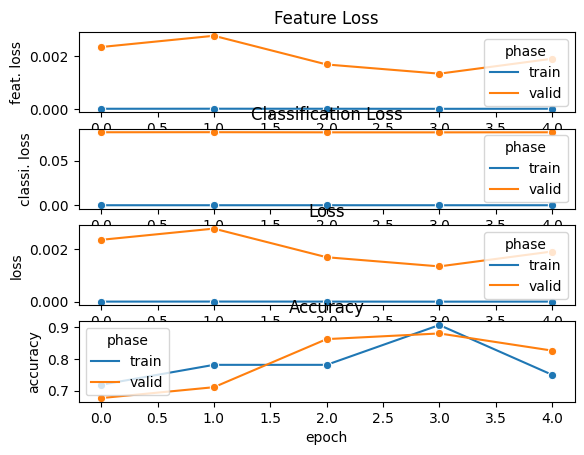

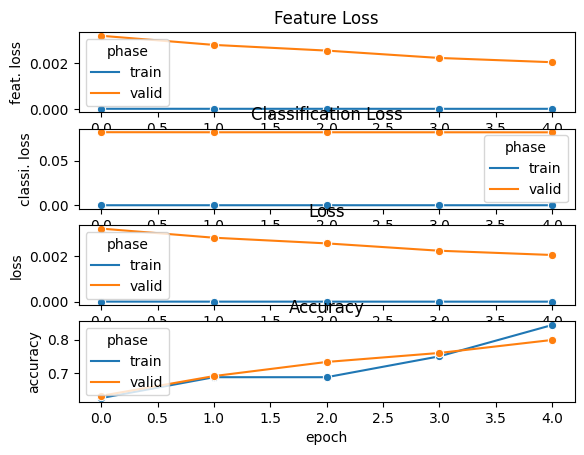

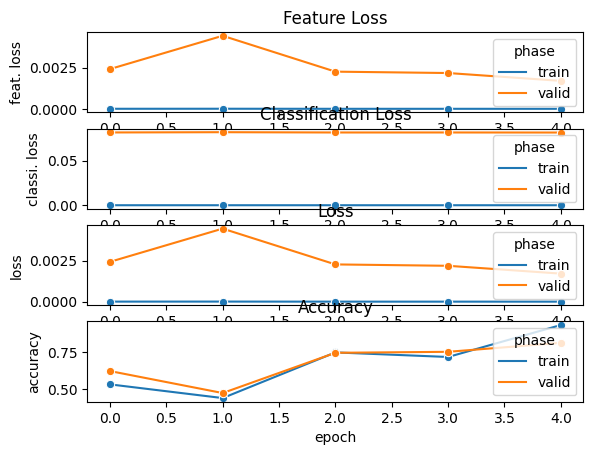

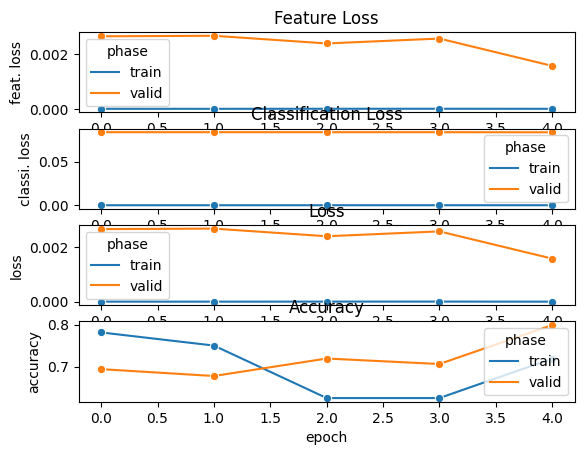

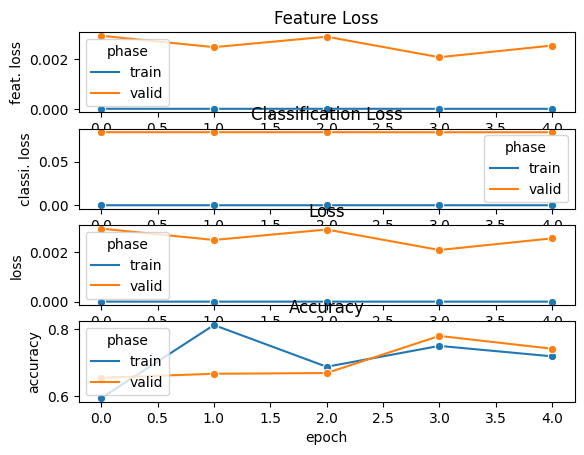

In [24]:
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.1, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = IMUDataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = IMUDataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = IMUDataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt, optimizer, loss_module, device, phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=False)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
